# Code to Plot results of CEF fit to $\rm{Pr_3Sb_3Mg_2O_{14}}$ data

Allen Scheie
December, 2017

at this point, we've fit a point charge model and then fit the CEF parameters directly.

In [1]:
# Import libraries
%matplotlib notebook
# Import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
import sys
import CEF_calculations as cef
import time


#Plot Formatting stuff
#########################################################################
#mpl.style.use('default')
import seaborn.apionly as sns
from cycler import cycler
cpal1 = sns.choose_colorbrewer_palette('qualitative')

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans',
          'xtick.direction':'in', 'ytick.direction': 'in',
          'xtick.top': True,'ytick.right': True,
          'font.size': 15, 'axes.prop_cycle': cycler('color',cpal1)}
plt.rcParams.update(params)

def my_formatter(x, pos):
    """Format 0.0 as 0"""
    if x == 0.00: return '{:g}'.format(x)
    else: return x
#########################################################################


# Put the above values for the Debye Waller factor in a dictionary
AtomDisp = {}
AtomDisp['NdMg'] = {}
AtomDisp['NdMg'][6] = 0.0
AtomDisp['NdMg'][100] = 0.045148437500000055
AtomDisp['NdMg'][200] = 0.084953125000000129

AtomDisp['NdZn'] = {}
AtomDisp['NdZn'][6] = 0.0
AtomDisp['NdZn'][100] = 0.045175781250000054
AtomDisp['NdZn'][200] = 0.087765625000000125

AtomDisp['PrMg'] = {}
AtomDisp['PrMg'][6] = 0.0
AtomDisp['PrMg'][100] = 0.045941406250000053
AtomDisp['PrMg'][200] = 0.076910156250000111



# Import Resolution Function

resf150 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc150.txt', skip_header=1, unpack=True)
resf80 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc80.txt', skip_header=1, unpack=True)
resf40 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc40.txt', skip_header=1, unpack=True)

def resfunc(Ei, deltaE):
    if Ei == 150:
        deltaE = np.interp(deltaE, resf150[0], resf150[1])
    elif Ei == 80:
        deltaE =  np.interp(deltaE, resf80[0], resf80[1])
    elif Ei == 40:
        deltaE =  np.interp(deltaE, resf40[0], resf40[1])
    else: print("Ei not in resfunc data.")
    return deltaE



# Test out NeutronSpectrum2D function
Qarray = np.arange(0.1,15,0.1)
Earray = np.arange(5,150,0.5)

def arrayedges(xarray):
    diff = (xarray[1:] - xarray[:-1]) / 2.  # get edges of arrays
    return np.hstack((xarray[0]-diff[0], xarray[:-1]+diff, xarray[-1]+diff[-1]))
Eedges = arrayedges(Earray)
Qedges = arrayedges(Qarray)

/home/allen/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


A Jupyter Widget

[6, 6, 6, 100, 100, 100, 200, 200, 200]
[40, 80, 150, 40, 80, 150, 40, 80, 150]


<IPython.core.display.Javascript object>


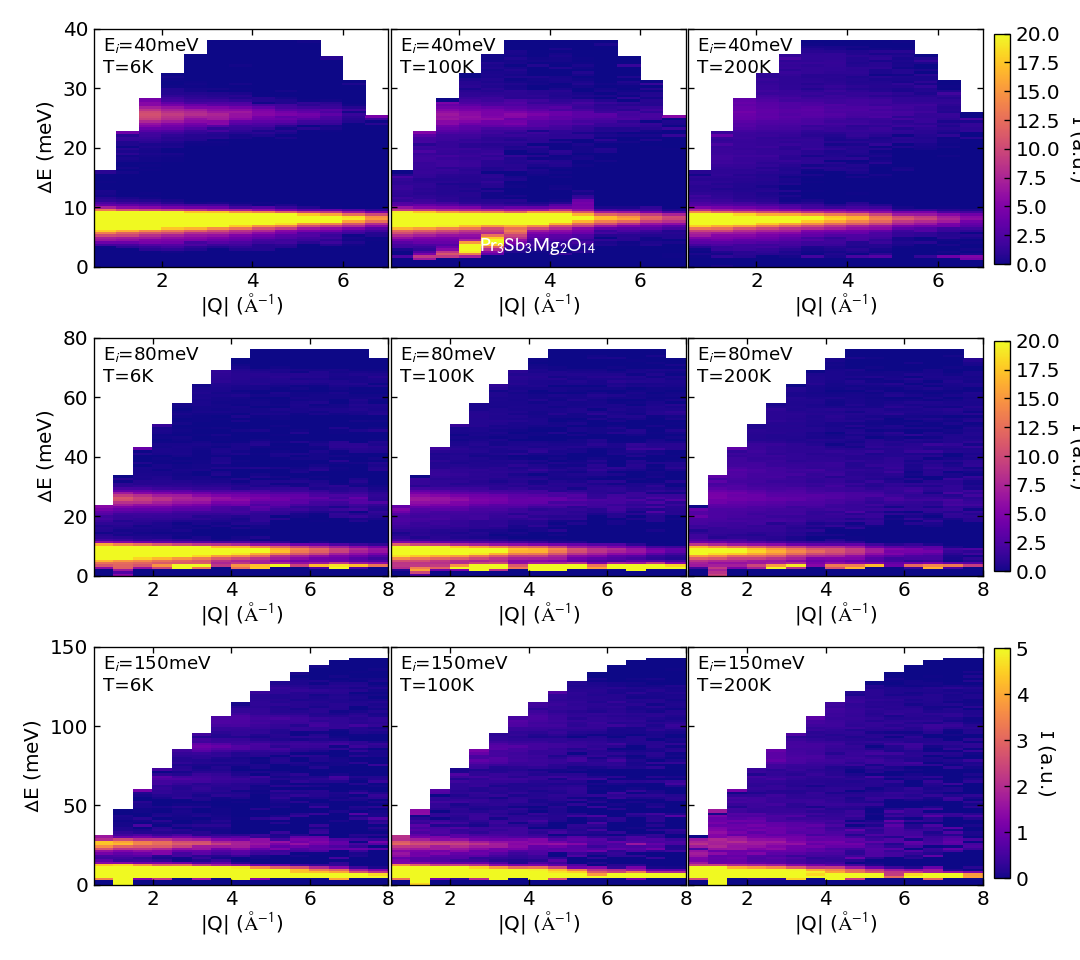

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [2]:
# ### Import Susceptibility data
# Import data
datafile = './Data/'+\
                'Pr3Sb3Mg2O14.dc.dat'
#ImportData
DataA = np.genfromtxt(datafile, delimiter=',', skip_header=31)
Temp = DataA[:,3]
Mag = DataA[:,4]

#Normalize the data
mass = 0.0583 #mass in g of sample
Molarmass = 3*140.90766 + 3*121.76 + 2*24.305 + 14*15.9994  #molar mass of sample (g/mol)
field = 1000

NormMag = Mag / mass * Molarmass / 3 / field
Chiminus1 = 1/NormMag  # in emu/Oe/mol
Chiminus1 *= 1/(1.078283e20*10000/6.0221409e23)  # in mu_B/T/ion


# Import data
slicesdirectory = './Data/Slices/'

# Define file names by my naming convention
filenames = []
for T in [6, 100, 200]:
    for E in [40,80,150]:
        filenames.append('PrMg_T'+str(T)+'_E'+str(E)+'_slice.iexy')

data = [cef.importGridfile(slicesdirectory+f) for i,f in enumerate(filenames)]
# # Intensity Error |Q| DeltaE

datatemps = [int(name.split('_')[1][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION
dataengys = [int(name.split('_')[2][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION

print(datatemps)
print(dataengys)

#print data[1][0]



ntemps = len(set(datatemps))
nengys = len(set(dataengys))


plt.rc('font',**{'size':12})
    
f, ax = plt.subplots(3,3, figsize=(9,8))


cax1 = f.add_axes([0.92,0.725,0.015,0.24])
cax2 = f.add_axes([0.92,0.405,0.015,0.24])
cax3 = f.add_axes([0.92,0.085,0.015,0.24])
cax = [cax1, cax2, cax3]

minImaxI = [(0,0.002),(0,0.002),(0,0.0005)]
cmap = 'plasma'
for i in range(nengys):
    minI, maxI = minImaxI[i]
    for j in range(ntemps):
        k = j*ntemps + i
        try: 
            intensity = np.ma.masked_where(np.isnan(data[k]['I']), data[k]['I'])
            ax[i,j].pcolormesh(arrayedges(data[k]['Q']), arrayedges(data[k]['E']), intensity, 
                               rasterized = True, cmap = cmap, vmin = minI, vmax = maxI)
            # Set axis labels
            if j == 0: ax[i,j].set_ylabel('$\Delta$E (meV)')
            else: ax[i,j].yaxis.set_ticklabels([])
            ax[i,j].set_xlabel('|Q| ($\\rm \AA^{-1}$)', labelpad=0)
            # set text in frame
            ax[i,j].text(0.03, 0.97, 'E$_i$='+str(dataengys[k])+'meV'+'\nT='+str(datatemps[k])+'K', fontsize=11,
                        horizontalalignment='left',verticalalignment='top', transform=ax[i,j].transAxes)
        except IndexError:
            break
            
    norm = Normalize(vmin=minI*1e4, vmax=maxI*1e4)
    mappable = cm.ScalarMappable(norm = norm, cmap=cmap)
    mappable.set_array([])
    cb = f.colorbar(mappable, cax[i], cmap =cmap, norm=norm ,orientation='vertical',
                       ticklocation = 'right',drawedges = False)
    cb.solids.set_edgecolor("face")
    #cb.set_ticks(MultipleLocator(0.02))
    cb.formatter.set_powerlimits((-1, 2))
    cb.ax.xaxis.set_label_coords(1.24,0.6)
    #cb.ax.xaxis.set_major_formatter(FormatStrFormatter('%f'))
    cb.set_label('$\\rm I$ (a.u.)', rotation = -90, labelpad = 17)

ax[0,1].text(0.5,0.04,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$', color='w',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[0,1].transAxes)
    
plt.tight_layout()
f.subplots_adjust(wspace=0.01, hspace=0.3, right=0.91)
plt.show()

<IPython.core.display.Javascript object>


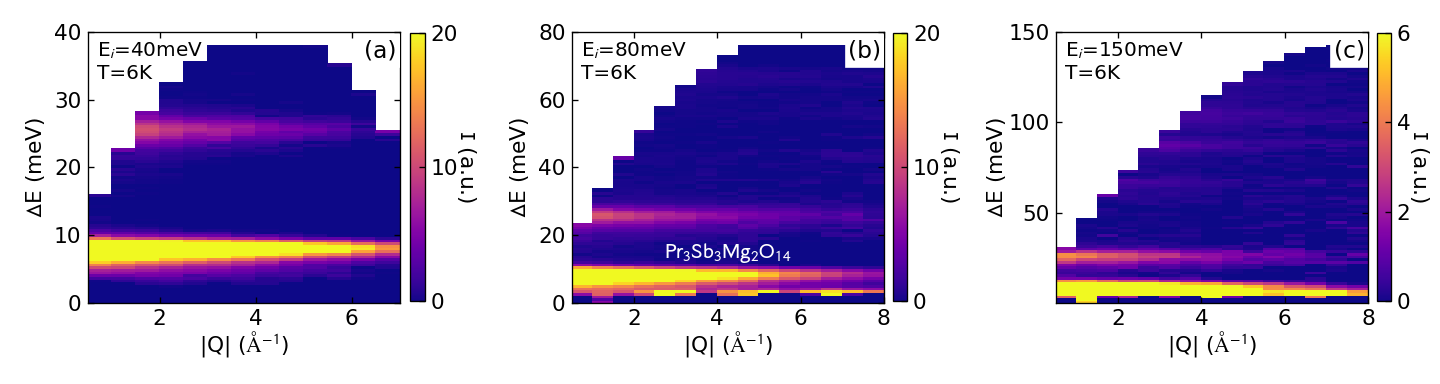

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [3]:
plt.rc('font',**{'size':13})
    
f, ax = plt.subplots(1,3, figsize=(12,3.2))


cax1 = f.add_axes([0.285,0.215,0.01,0.7])
cax2 = f.add_axes([0.62,0.215,0.01,0.7])
cax3 = f.add_axes([0.956,0.215,0.01,0.7])
cax = [cax1, cax2, cax3]

minImaxI = [(0,0.002),(0,0.002),(0,0.0006)]
cmap = 'plasma'
axeslabels = 'abcdefghijk'
for i in range(nengys):
    minI, maxI = minImaxI[i]
    k = i
    try: 
        intensity = np.ma.masked_where(np.isnan(data[k]['I']), data[k]['I'])
        ax[i].pcolormesh(arrayedges(data[k]['Q']), arrayedges(data[k]['E']), intensity, 
                           rasterized = True, cmap = cmap, vmin = minI, vmax = maxI)
        # Set axis labels
        ax[i].set_ylabel('$\Delta$E (meV)')
        ax[i].set_xlabel('|Q| ($\\rm \AA^{-1}$)', labelpad=0)
        # set text in frame
        ax[i].text(0.03, 0.97, 'E$_i$='+str(dataengys[k])+'meV'+'\nT='+str(datatemps[k])+'K', fontsize=12,
                    horizontalalignment='left',verticalalignment='top', transform=ax[i].transAxes)
    except IndexError:
        break
            
    norm = Normalize(vmin=minI*1e4, vmax=maxI*1e4)
    mappable = cm.ScalarMappable(norm = norm, cmap=cmap)
    mappable.set_array([])
    cb = f.colorbar(mappable, cax[i], cmap =cmap, norm=norm ,orientation='vertical',
                       ticklocation = 'right',drawedges = False)
    cb.solids.set_edgecolor("face")
    #cb.set_ticks(MultipleLocator(0.02))
    cb.formatter.set_powerlimits((-1, 2))
    cb.ax.xaxis.set_label_coords(1.24,0.6)
    #cb.ax.xaxis.set_major_formatter(FormatStrFormatter('%f'))
    cb.set_label('$\\rm I$ (a.u.)', rotation = -90, labelpad = 12)
    if i in [0,1]:
        cb.set_ticks([0,10,20])
    else:
        cb.set_ticks([0,2,4,6])
        
    # Set axes labels
    rect = patches.Rectangle((0.88,0.87),0.12,0.12, facecolor='white', edgecolor='w',
                         transform=ax[i].transAxes, zorder=10)
    ax[i].add_patch(rect)
    ax[i].text(0.99, 0.97, '('+axeslabels[i]+')', fontsize=14, zorder=10,
                horizontalalignment='right',verticalalignment='top', transform=ax[i].transAxes)

ax[2].set_ylabel('$\Delta$E (meV)',labelpad=0)
ax[2].set_yticks([50,100,150])

    
ax[1].text(0.5,0.14,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$', color='w',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[1].transAxes)
    
plt.tight_layout()
f.subplots_adjust(wspace=0.55, right=0.95)
plt.show()

<IPython.core.display.Javascript object>


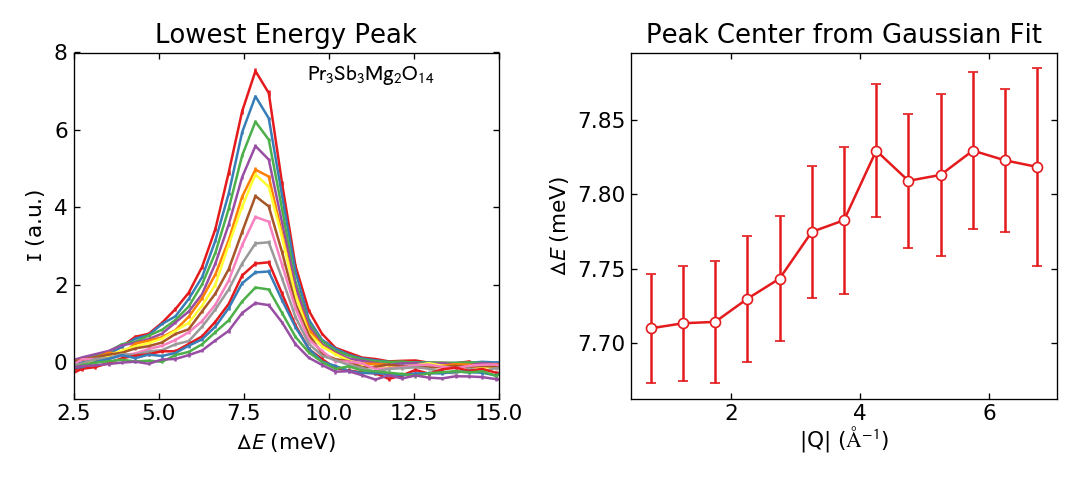

0.0141128296109
0.00474554618808 0.00618491931475


In [4]:
### Check for dispersion of lowest CEF level

# intensity = np.ma.masked_where(np.isnan(data[k]['I']), data[k]['I'])
#         ax[i].pcolormesh(arrayedges(data[k]['Q']), arrayedges(data[k]['E']), intensity, 

from AutoGaussian import autoGaussianFit

f, ax = plt.subplots(1,2,figsize=(9,4))
qarr=[]
x0arr = []
dx0arr = []
for i in range(0,len(data[0]['Q'])):
    qarr.append(data[0]['Q'][i])
    ll, ul = 6, 40
    xg, yg, dyg = arrayedges(data[0]['E'])[ll:ul],data[0]['I'][ll:ul,i],data[0]['dI'][ll:ul,i]
    nonnan = np.where(~np.isnan(yg))
    res = autoGaussianFit(xg[nonnan], yg[nonnan], sigma=dyg[nonnan])
    x0arr.append(res[0]['x0'])
    dx0arr.append(res[1]['x0'])
    ax[0].errorbar(xg,yg*1000,dyg*1000)
ax[0].set_xlim(2.5,15)
ax[0].set_ylabel('$\\rm I$ (a.u.)')
ax[0].set_xlabel('$\\Delta E$ (meV)')
    
ax[0].text(0.7,0.9,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[0].transAxes)
ax[0].set_title('Lowest Energy Peak')
    
ax[1].errorbar(qarr, x0arr, dx0arr, capsize=3, marker='o', mfc='w')
ax[1].set_ylabel('$\\Delta E$ (meV)')
ax[1].set_xlabel('|Q| ($\\rm \AA^{-1}$)', labelpad=0)
plt.tight_layout()

ax[1].set_title('Peak Center from Gaussian Fit')

print(x0arr[-1]/x0arr[0]-1)
print(dx0arr[0]/x0arr[0], dx0arr[-2]/x0arr[-2])

In [5]:
import pickle

with open('PrMg_CEF_fitResults.pickle', 'rb') as f:
    NdCoefFit1, FitB, FitGamma, FitPrefactors = pickle.load(f)
    #NdCoefFit1, FitCoefficients, FitGamma, FitPrefactors = pickle.load(f)

with open('PrMg_CEF_PC_fitResults.pickle', 'rb') as f:
    NdPCCoefFit1, NdPCFitB = pickle.load(f)
    
NdCoefFit1.diagonalize()
NdCoefFit1.printLaTexEigenvectors()
NdCoefFit1.printEigenvectors()
NdCoefFit1.gsExpectation()

NdPCCoefFit1.diagonalize()
NdPCCoefFit1.printLaTexEigenvectors()
NdPCCoefFit1.gsExpectation()

\begin{table*}
\caption{Eigenvectors and Eigenvalues...}
\begin{ruledtabular}
\begin{tabular}{c|ccccccccc}
E (meV) &$|-4\rangle$ & $|-3\rangle$ & $|-2\rangle$ & $|-1\rangle$ & $|0\rangle$ & $|1\rangle$ & $|2\rangle$ & $|3\rangle$ & $|4\rangle$ \tabularnewline
 \hline 
0.000 & 0.3301 & 0.0176 & 0.2111 & -0.0663 & -0.8268 & 0.0663 & 0.2111 & -0.0176 & 0.3301 \tabularnewline
7.857 & 0.1378 & -0.0761 & 0.0021 & -0.6723 & 0.2156 & 0.6723 & 0.0021 & 0.0761 & 0.1378 \tabularnewline
25.982 & 0.5732 & -0.0511 & 0.294 & -0.287 & 0.0 & -0.287 & -0.294 & -0.0511 & -0.5732 \tabularnewline
62.734 & 0.5925 & -0.1582 & -0.1293 & 0.198 & 0.3686 & -0.198 & -0.1293 & 0.1582 & 0.5925 \tabularnewline
86.585 & -0.3312 & 0.2206 & 0.1273 & -0.5704 & 0.0 & -0.5704 & -0.1273 & 0.2206 & 0.3312 \tabularnewline
106.952 & 0.2236 & 0.1408 & -0.6201 & -0.2138 & -0.0 & -0.2138 & 0.6201 & 0.1408 & -0.2236 \tabularnewline
122.734 & -0.0693 & -0.3987 & 0.5582 & 0.0651 & 0.2022 & -0.0651 & 0.5582 & 0.3987 & -0.0693 \tabul

3.25 2.75 3.75
3.25 2.75 3.75
5.25 4.75 5.75


<IPython.core.display.Javascript object>


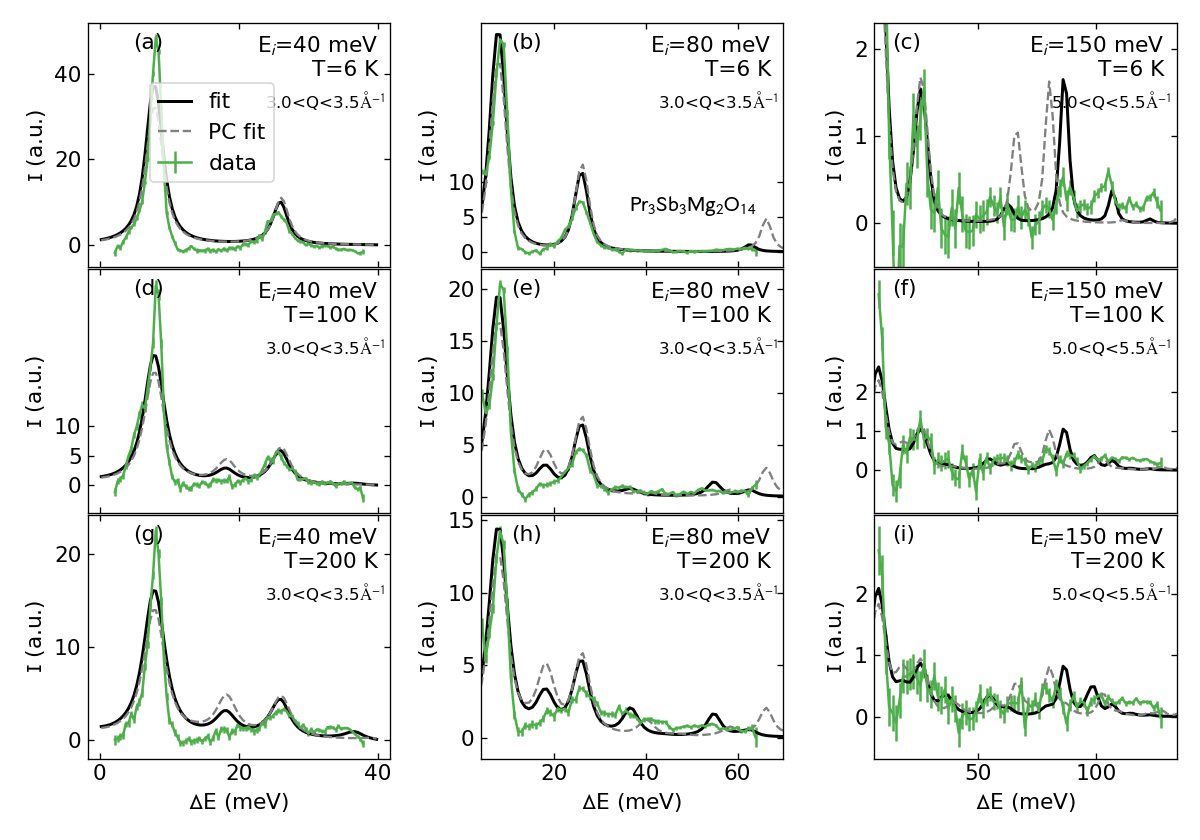

In [6]:
print(data[0]['Q'][5], data[0]['Q'][4], data[0]['Q'][6])
print(data[1]['Q'][5], data[1]['Q'][4], data[1]['Q'][6])
print(data[2]['Q'][9], data[2]['Q'][8], data[2]['Q'][10])
Qlim = {40:5, 80:5, 150:9}  #indices of the Q cuts that we want to plot


gammas = np.repeat(FitGamma, len(set(datatemps)))
prefc = np.tile(FitPrefactors, len(dataengys))
Nd_intens = []
Nd_PC_intens = []
Nd_fitx = []
for i, t in enumerate(datatemps):
    Nd_intens.append(prefc[i]*NdCoefFit1.neutronSpectrum2D(Earray=data[i]['E'], Qarray = data[i]['Q'], Temp=t, 
                                                Ei=dataengys[i], ResFunc=lambda de: resfunc(dataengys[i],de), 
                                                gamma=gammas[i],DebyeWaller = AtomDisp['NdMg'][t], Ion = 'Nd3+') )
    Nd_PC_intens.append(prefc[i]*NdPCCoefFit1.neutronSpectrum2D(Earray=data[i]['E'], Qarray = data[i]['Q'], Temp=t, 
                                                Ei=dataengys[i], ResFunc=lambda de: resfunc(dataengys[i],de), 
                                                gamma=gammas[i],DebyeWaller = AtomDisp['NdMg'][t], Ion = 'Nd3+') )

cpal = plt.cm.tab10(np.arange(10))
f, ax = plt.subplots(3,3, figsize=(10,7))

axeslabels = 'abcdefghijk'
multfac = 10000
for i in range(ntemps):
    for j in range(nengys):
        k = i*ntemps + j
        try: 
            ax[i,j].errorbar(data[k]['E'][5:], multfac*data[k]['I'][5:,Qlim[dataengys[k]]], 
                             multfac*data[k]['dI'][5:,Qlim[dataengys[k]]], color=cpal1[2], label='data')
            ax[i,j].plot(data[k]['E'], multfac*Nd_intens[k][:,Qlim[dataengys[k]]], lw=1.8,
                        label='fit', color='k')
            ax[i,j].plot(data[k]['E'], multfac*Nd_PC_intens[k][:,Qlim[dataengys[k]]], lw=1.4,
                        label='PC fit', color='grey', ls='--')
            ax[i,j].set_ylabel('$\\rm I$ (a.u.)')
            #ax[i,j].set_xlabel('$\Delta$E (meV)')
            #ax[i,j].set_ylim(0,0.0006)
            #ax[i,j].legend(frameon=False, fontsize=14)
            ax[i,j].text(0.96,0.96,'E$_i$='+str(dataengys[k])+' meV\n'+'T='+str(datatemps[k])+' K',
                horizontalalignment='right',verticalalignment='top', transform=ax[i,j].transAxes)
            ax[i,j].text(0.98,0.73, 
                         str(np.mean(data[0]['Q'][Qlim[dataengys[k]]-1:Qlim[dataengys[k]]+1]))+'<Q<'+
                         str(np.mean(data[0]['Q'][Qlim[dataengys[k]]:Qlim[dataengys[k]]+2]))+
                         '$\\rm \AA^{-1}$', fontsize=10,
                horizontalalignment='right',verticalalignment='top', transform=ax[i,j].transAxes)
            if i == 2: ax[i,j].set_xlabel('$\Delta$E (meV)')
            else: ax[i,j].xaxis.set_ticklabels([])
            #ax[i,j].set_title('T='+str(datatemps[k])+' K,  '+'E$_i$='+str(dataengys[k])+' meV', fontsize=15)
            
            if j == 1: 
                ax[i,j].set_xlim(4,70)
            elif j == 2:
                ax[i,j].set_xlim(6,134)
                ax[i,j].set_yticks([0,1,2])
            
            # Label panels
            if j == 0:
                ax[i,j].text(0.15, 0.96, '('+axeslabels[i*ntemps + j]+')', fontsize=13, zorder=10,
                    horizontalalignment='left',verticalalignment='top', transform=ax[i,j].transAxes)
            elif j == 1:
                ax[i,j].text(0.1, 0.96, '('+axeslabels[i*ntemps + j]+')', fontsize=13, zorder=10,
                    horizontalalignment='left',verticalalignment='top', transform=ax[i,j].transAxes)
            elif j == 2:
                ax[i,j].text(0.06, 0.96, '('+axeslabels[i*ntemps + j]+')', fontsize=13, zorder=10,
                    horizontalalignment='left',verticalalignment='top', transform=ax[i,j].transAxes)
            
        except IndexError:
            break

ax[0,0].legend(loc=6, handlelength=1.5, bbox_to_anchor=(0.17,0.55))
ax[0,1].text(0.7,0.2,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[0,1].transAxes)

# Fix some of the axes
ax[1,0].set_yticks([0,5,10])
ax[0,1].set_yticks([0,5,10])
ax[0,2].set_ylim(-0.5,2.3)

plt.tight_layout()
f.subplots_adjust(hspace=0.01)

<IPython.core.display.Javascript object>


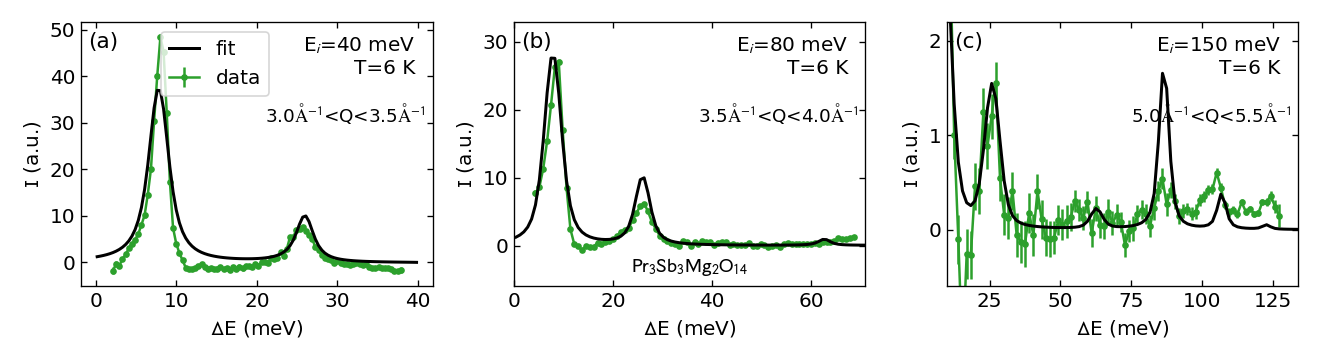

In [7]:
#cpal = plt.cm.Set1(np.arange(9))
cpal = plt.cm.tab10(np.arange(10))
#cpal = plt.cm.Dark2(np.arange(8))

Qlim = {40:5, 80:6, 150:9}

plt.rc('font',**{'size':12})

f, ax = plt.subplots(1,3, figsize=(11,3))

axeslabels = 'abcdefghijk'
multfac = 10000
for i in range(ntemps):
    k = i
    try: 
        ax[i].errorbar(data[k]['E'][5:], multfac*data[k]['I'][5:,Qlim[dataengys[k]]], 
                         multfac*data[k]['dI'][5:,Qlim[dataengys[k]]],
                       marker='.',color=cpal[2], label='data')
        ax[i].plot(data[k]['E'], multfac*Nd_intens[k][:,Qlim[dataengys[k]]], lw=1.8,
                    color='k', label='fit', zorder=5)
        ax[i].set_ylabel('$\\rm I$ (a.u.)')
        #ax[i,j].set_xlabel('$\Delta$E (meV)')
        #ax[i,j].set_ylim(0,0.0006)
        #ax[i,j].legend(frameon=False, fontsize=14)
        ax[i].text(0.95,0.95,'E$_i$='+str(dataengys[k])+' meV\n'+'T='+str(datatemps[k])+' K',
            horizontalalignment='right',verticalalignment='top', transform=ax[i].transAxes)
        ax[i].text(0.98,0.7, 
                     str(np.mean(data[0]['Q'][Qlim[dataengys[k]]-1:Qlim[dataengys[k]]+1]))+'$\\rm \AA^{-1}$'+
                       '<Q<'+
                     str(np.mean(data[0]['Q'][Qlim[dataengys[k]]:Qlim[dataengys[k]]+2]))+
                     '$\\rm \AA^{-1}$', fontsize=11,
            horizontalalignment='right',verticalalignment='top', transform=ax[i].transAxes)
        ax[i].set_xlabel('$\Delta$E (meV)')
        #ax[i,j].set_title('T='+str(datatemps[k])+' K,  '+'E$_i$='+str(dataengys[k])+' meV', fontsize=15)

        if i == 1: 
            ax[i].set_xlim(0,71)
            ax[i].set_ylim(-6,33)
        elif i == 2:
            ax[i].set_xlim(10,134)
            ax[i].set_ylim(-0.6,2.2)
            ax[i].set_yticks([0,1,2])

        # Label panels
        ax[i].text(0.02, 0.96, '('+axeslabels[i]+')', fontsize=13, zorder=10,
                horizontalalignment='left',verticalalignment='top', transform=ax[i].transAxes)

    except IndexError:
        break

ax[0].legend(loc=2, bbox_to_anchor=(0.2,1), handlelength=1.5)            
ax[1].text(0.5,0.03,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[1].transAxes)

plt.tight_layout()
f.subplots_adjust(hspace=0.01)

<IPython.core.display.Javascript object>


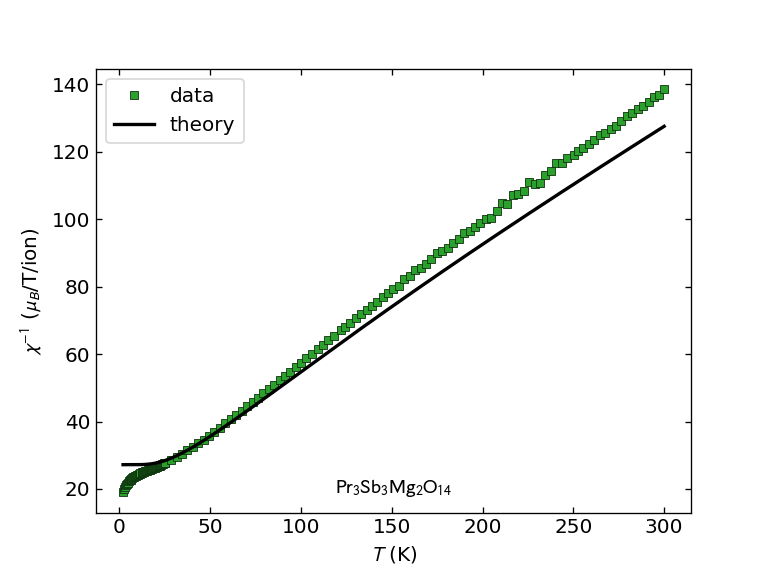

Text(0.5,0.03,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$')

In [8]:

calcsuscep = NdCoefFit1.susceptibility('Pr3+', Temp,  0.5, 0.001)

f, ax = plt.subplots()
plt.plot(Temp,Chiminus1, 's', markersize=5,mew=0.5,mec=cpal[2]*np.array([0.3,0.3,0.3,1]), 
         label='data', color=cpal[2])
plt.plot(Temp,-1/calcsuscep, label='theory', lw=2, c='k')
plt.xlabel('$T$ (K)')
plt.ylabel('$\chi^{-1}$ ($\mu_B$/T/ion)')
plt.legend()
ax.text(0.5,0.03,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
        horizontalalignment='center',verticalalignment='bottom', transform=ax.transAxes)

[  9.78759659e-01   4.09567986e-02   1.75897149e-04]
[ 0.90000888  2.34190946 -4.75472351] [ 0.0039144   0.01559408  0.26758716]


<IPython.core.display.Javascript object>


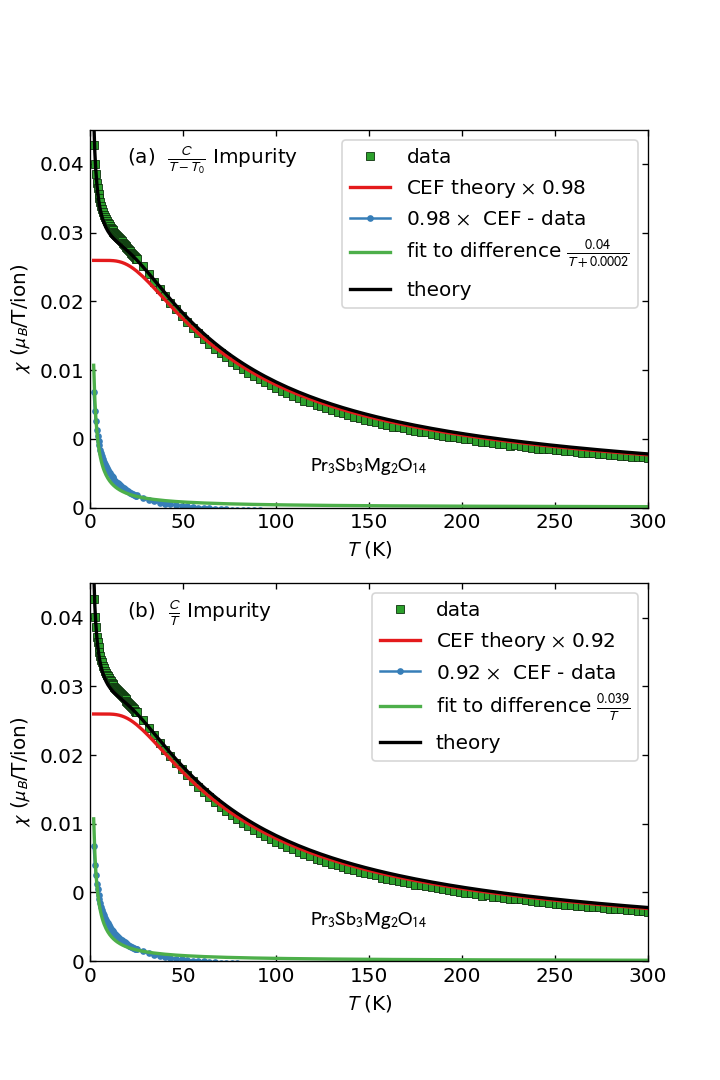

Effective Moment of Impurity = 2.93460451144  muB
[ 0.97875664  0.04097598]
Effective Moment of Impurity = 2.93508334131  muB


In [9]:
from scipy.optimize import minimize, curve_fit

def fun(pp):
    return np.sum((1/Chiminus1 + pp[0]*calcsuscep - pp[1]/(Temp-pp[2]))**2)
p0 = [0.90,0.05,0.0]
res1 = minimize(fun,p0, method='Nelder-Mead')
print(res1.x)

def funf(x, A, B, C):
    return -A*calcsuscep + (1-A)*(B/2.11333)**2/(x-C)
    #return -A*calcsuscep + (1-A)*B/(x-C)
p0 = [0.97,2.934,0.0]
popt1, pcov1 = curve_fit(funf, Temp, 1/Chiminus1, p0)
print(popt1, np.diag(pcov1)**0.5)

difference = 1/Chiminus1 + res1.x[0]*calcsuscep


f, ax = plt.subplots(2,1,figsize=(6,9))
ax[0].plot(Temp,1/Chiminus1, 's', markersize=5,mew=0.5,mec=cpal[2]*np.array([0.3,0.3,0.3,1]), 
         label='data', color=cpal[2])
ax[0].plot(Temp,-res1.x[0]*calcsuscep, label='CEF theory $\\times$ 0.98', lw=2)
ax[0].plot(Temp,difference, label='0.98 $\\times$  CEF - data', marker='.')
ax[0].plot(Temp,res1.x[1]/(Temp-res1.x[2]), label='fit to difference $\\frac{0.04}{T+0.0002}$', lw=2)
ax[0].plot(Temp,res1.x[1]/(Temp-res1.x[2])-res1.x[0]*calcsuscep, label='theory', lw=2, c='k')
ax[0].set_xlabel('$T$ (K)')
ax[0].set_ylabel('$\chi$ ($\mu_B$/T/ion)')
ax[0].legend()
ax[0].text(0.5,0.08,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
        horizontalalignment='center',verticalalignment='bottom', transform=ax[0].transAxes)

ax[0].set_yticklabels([0,'0',0.01,0.02,0.03,0.04,0.05])
ax[0].set_xlim(0,300)

print('Effective Moment of Impurity =',2.11333*np.sqrt(1/(1-res1.x[0])*res1.x[1]), ' muB')


def fun(pp):
    return np.sum((1/Chiminus1 + pp[0]*calcsuscep - pp[1]/(Temp))**2)
p0 = [0.90,0.05]
res2 = minimize(fun,p0, method='Nelder-Mead')
print(res2.x)

difference = 1/Chiminus1 + res2.x[0]*calcsuscep

ax[1].plot(Temp,1/Chiminus1, 's', markersize=5,mew=0.5,mec=cpal[2]*np.array([0.3,0.3,0.3,1]), 
         label='data', color=cpal[2])
ax[1].plot(Temp,-res2.x[0]*calcsuscep, label='CEF theory $\\times$ 0.92', lw=2)
ax[1].plot(Temp,difference, label='0.92 $\\times$  CEF - data', marker='.')
ax[1].plot(Temp,res2.x[1]/(Temp), label='fit to difference $\\frac{0.039}{T}$', lw=2)
ax[1].plot(Temp,res2.x[1]/(Temp)-res2.x[0]*calcsuscep, label='theory', lw=2, c='k')
ax[1].set_xlabel('$T$ (K)')
ax[1].set_ylabel('$\chi$ ($\mu_B$/T/ion)')
ax[1].legend()
ax[1].text(0.5,0.08,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
        horizontalalignment='center',verticalalignment='bottom', transform=ax[1].transAxes)

ax[1].set_yticklabels([0,'0',0.01,0.02,0.03,0.04,0.05])
ax[1].set_xlim(0,300)
ax[1].set_ylim(0,0.055)
ax[0].set_ylim(0,0.055)

ax[0].text(20,0.05, "(a)  $\\frac{C}{T-T_0}$ Impurity")
ax[1].text(20,0.05, "(b)  $\\frac{C}{T}$ Impurity")

print('Effective Moment of Impurity =',2.11333*np.sqrt(1/(1-res2.x[0])*res2.x[1]), ' muB')

figdir = '/home/allen/Documents/Neutrons/Nd3Sb3Mg2O14/ARCS_Exp/Paper/Figures/'
plt.savefig(figdir+'NdKag_Fig_PrMg_SusceptibilityExamination01.pdf',  bbox_inches='tight',pad_inches = 0.01)

<IPython.core.display.Javascript object>


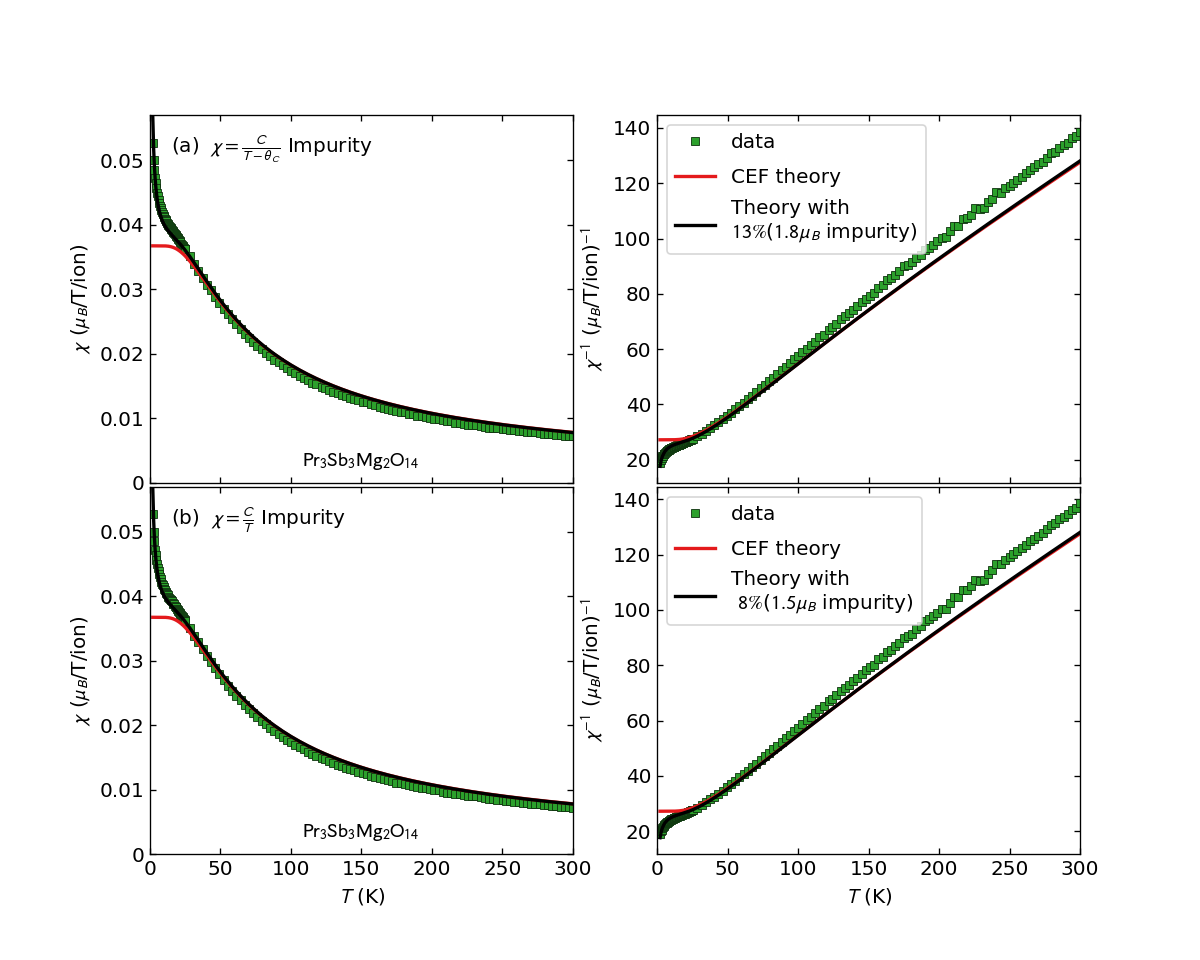

Effective Moment of Impurity = 2.93460451144  muB
Effective Moment of Impurity = 2.93508334131  muB


In [10]:
f, axes = plt.subplots(2,2,figsize=(10,8), sharex=True)
ax = [axes[0,0],axes[1,0],axes[0,1],axes[1,1]]
ax[0].plot(Temp,1/Chiminus1, 's', markersize=5,mew=0.5,mec=cpal[2]*np.array([0.3,0.3,0.3,1]), 
         label='data', color=cpal[2])
ax[0].plot(Temp,-calcsuscep, label='CEF theory', lw=2)
ax[0].plot(Temp,res1.x[1]/(Temp-res1.x[2])-res1.x[0]*calcsuscep, 
           label='Theory with\n$13 \\%$($1.8 \mu_B$ impurity)', lw=2, c='k')
ax[0].set_ylabel('$\chi$ ($\mu_B$/T/ion)')
ax[0].text(0.5,0.03,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
        horizontalalignment='center',verticalalignment='bottom', transform=ax[0].transAxes)

ax[2].plot(Temp,Chiminus1, 's', markersize=5,mew=0.5,mec=cpal[2]*np.array([0.3,0.3,0.3,1]), 
         label='data', color=cpal[2])
ax[2].plot(Temp,-1/calcsuscep, label='CEF theory', lw=2)
ax[2].plot(Temp,1/(res1.x[1]/(Temp-res1.x[2])-res1.x[0]*calcsuscep), 
           label='Theory with\n$13 \\%$($1.8 \mu_B$ impurity)', lw=2, c='k')
ax[2].set_ylabel('$\chi^{-1}$ ($\mu_B$/T/ion)$^{-1}$')
ax[2].legend(labelspacing=0.8)


print('Effective Moment of Impurity =',2.11333*np.sqrt(1/(1-res1.x[0])*res1.x[1]), ' muB')

difference = 1/Chiminus1 + res2.x[0]*calcsuscep

ax[1].plot(Temp,1/Chiminus1, 's', markersize=5,mew=0.5,mec=cpal[2]*np.array([0.3,0.3,0.3,1]), 
         label='data', color=cpal[2])
ax[1].plot(Temp,-calcsuscep, label='CEF theory', lw=2)
ax[1].plot(Temp,res2.x[1]/(Temp)-res2.x[0]*calcsuscep, 
           label='Theory with\n $8\\%$($1.5 \mu_B$ impurity)', lw=2, c='k')
ax[1].set_xlabel('$T$ (K)')
ax[1].set_ylabel('$\chi$ ($\mu_B$/T/ion)')
ax[1].text(0.5,0.03,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
        horizontalalignment='center',verticalalignment='bottom', transform=ax[1].transAxes)

ax[3].plot(Temp,Chiminus1, 's', markersize=5,mew=0.5,mec=cpal[2]*np.array([0.3,0.3,0.3,1]), 
         label='data', color=cpal[2])
ax[3].plot(Temp,-1/calcsuscep, label='CEF theory', lw=2)
ax[3].plot(Temp,1/(res2.x[1]/(Temp)-res2.x[0]*calcsuscep), 
           label='Theory with\n $8\\%$($1.5 \mu_B$ impurity)', lw=2, c='k')
ax[3].set_ylabel('$\chi^{-1}$ ($\mu_B$/T/ion)$^{-1}$')
ax[3].set_xlabel('$T$ (K)')
ax[3].legend(labelspacing=0.8)

for axx in ax[:2]:
    axx.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05])
    axx.set_xlim(0,300)
    axx.set_ylim(0,0.057)

ax[0].text(0.05,0.95, "(a)  $\chi = \\frac{C}{T-\\theta_C}$ Impurity",
        horizontalalignment='left',verticalalignment='top', transform=ax[0].transAxes)
ax[1].text(0.05,0.95, "(b)  $\chi = \\frac{C}{T}$ Impurity",
        horizontalalignment='left',verticalalignment='top', transform=ax[1].transAxes)

print('Effective Moment of Impurity =',2.11333*np.sqrt(1/(1-res2.x[0])*res2.x[1]), ' muB')

f.subplots_adjust(hspace=0.01)

figdir = '/home/allen/Documents/Neutrons/Nd3Sb3Mg2O14/ARCS_Exp/Paper/Figures/'
# plt.savefig(figdir+'NdKag_Fig_PrMg_SusceptibilityExamination01.pdf',  bbox_inches='tight',pad_inches = 0.1)

0.12279113068162985


<IPython.core.display.Javascript object>


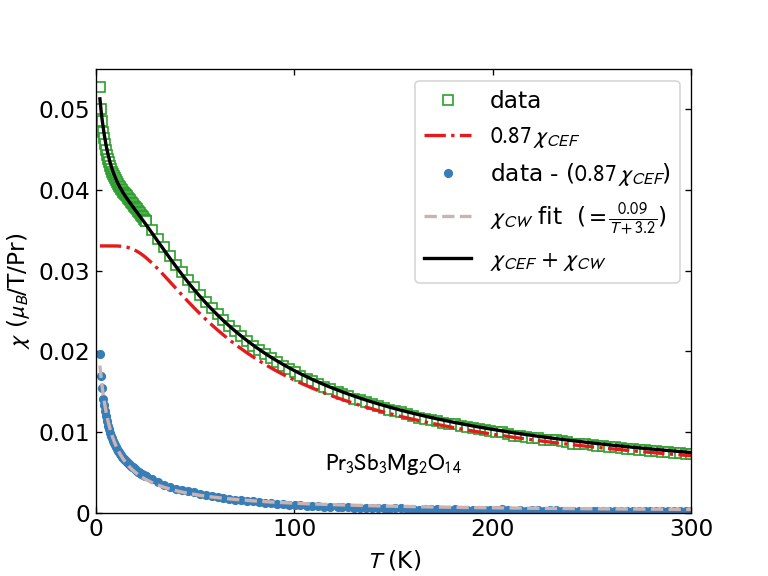

In [15]:
res1.x = [ 0.87137689,  0.09125306, -3.18776238]
res1.x = [ 0.90000888, (1-0.90000888)*(2.34190946/2.11333)**2, -4.75472351]
print(res1.x[1])

plt.rc('font',**{'size':14})
f, ax = plt.subplots(1,1)
difference = 1/Chiminus1 + res1.x[0]*calcsuscep
ax.plot(Temp,1/Chiminus1, 's', markersize=6,mew=1,mec=cpal[2], 
             c='w',label='data')
ax.plot(Temp,-res1.x[0]*calcsuscep, label='$0.87\>\chi_{CEF}$', lw=2, ls='-.')
ax.plot(Temp,difference, label='data - ($0.87\>\chi_{CEF}$)', marker='.', ls='none',ms=9)
ax.plot(Temp,res1.x[1]/(Temp-res1.x[2]), label='$\chi_{CW}$ fit  ($= \\frac{0.09}{T+3.2}$)',
        c=[0.8,0.7,0.7], lw=2, ls='--')
ax.plot(Temp,res1.x[1]/(Temp-res1.x[2])-res1.x[0]*calcsuscep, label='$\chi_{CEF} \>+\> \chi_{CW}$', 
        lw=2, c='k')
ax.set_xlabel('$T$ (K)')
ax.set_ylabel('$\chi$ ($\mu_B$/T/Pr)')
ax.legend()
ax.text(0.5,0.08,'$\\rm{Pr_3Sb_3Mg_2O_{14}}$',
        horizontalalignment='center',verticalalignment='bottom', transform=ax.transAxes)
# ax.text(30,0.008,'$\chi_{\\rm fit} = \\frac{0.09}{T+3.19}$')

ax.set_ylim(0,0.055)
ax.set_yticklabels(['0',0.01,0.02,0.03,0.04,0.05])
ax.set_xticks([0,100,200,300])
ax.set_xlim(0,300)

## Test: is the ground state easy axis or easy plane?

In [11]:
# Compute Magnetization
ion = 'Pr3+'

temp = 2
fieldstrengths = np.linspace(-150,150,100)
magnetization = np.zeros((len(fieldstrengths), 3, 3))
netmag = np.zeros(len(fieldstrengths))

theta, phi = 1, 1*np.pi/6
Bvect = np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])
Bvect = np.array([1,1,1])/np.sqrt(3)

for i, fs in enumerate(fieldstrengths):
    magnetization[i,0] = NdCoefFit1.magnetization(ion, temp, [fs,0,0])
    magnetization[i,1] = NdCoefFit1.magnetization(ion, temp, [0,fs,0])
    magnetization[i,2] = NdCoefFit1.magnetization(ion, temp, [0,0,fs])
    netmag[i] = -np.dot(Bvect, np.array(NdCoefFit1.magnetization(ion, temp, fs*Bvect)))

<IPython.core.display.Javascript object>


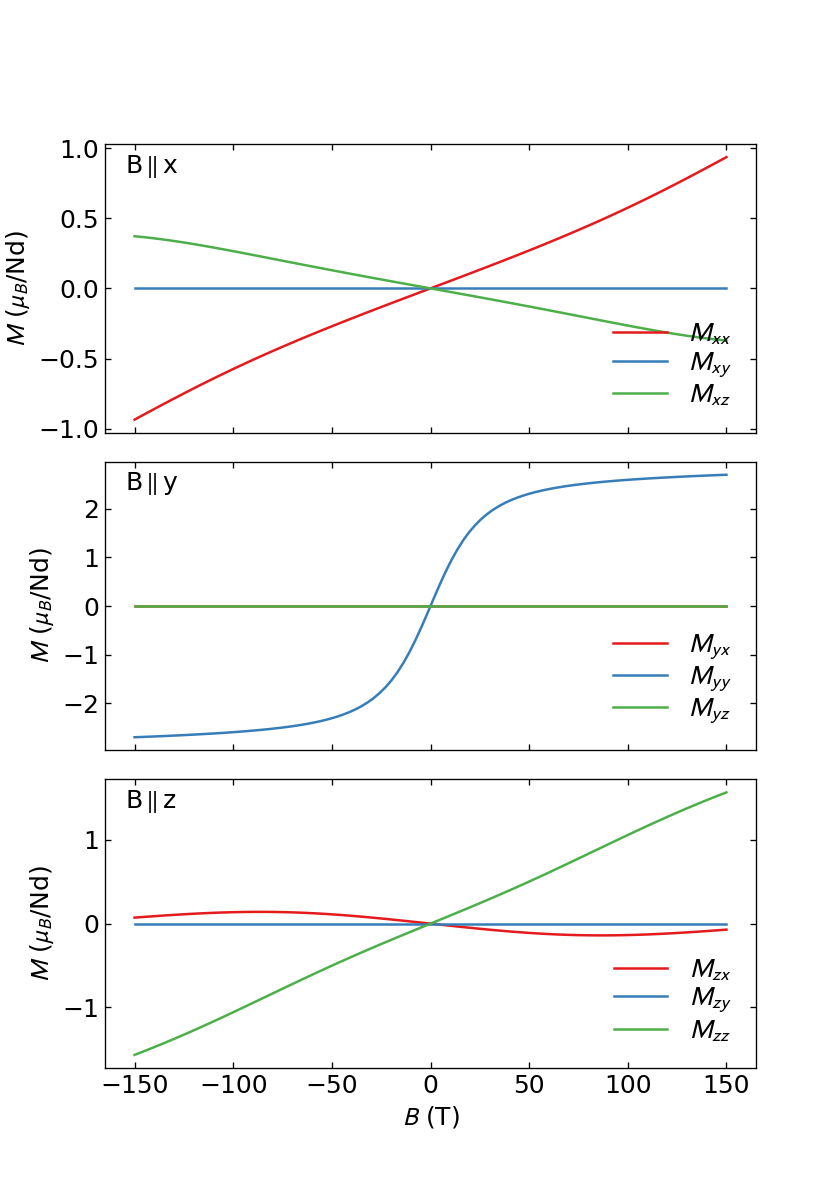

Text(0.5,0,'$B$ (T)')

In [12]:
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'font.size': 15}
plt.rcParams.update(params)

f, ax = plt.subplots(3,1, figsize=(7,10), sharex=True)
direction = ['x','y','z']
for i in range(3):
    ax[i].plot(fieldstrengths,-magnetization[:,i,0], label='$M_{'+direction[i]+'x}$')
    ax[i].plot(fieldstrengths,-magnetization[:,i,1], label='$M_{'+direction[i]+'y}$')
    ax[i].plot(fieldstrengths,-magnetization[:,i,2], label='$M_{'+direction[i]+'z}$')
    ax[i].text(0.03,0.97,'B$\\parallel$'+direction[i],
                horizontalalignment='left',verticalalignment='top', transform=ax[i].transAxes)
    ax[i].legend(loc=4, frameon=False,labelspacing = 0.1, fontsize=16)
    ax[i].set_ylabel('$M$ ($\mu_B$/Nd)')

f.subplots_adjust(hspace=0.1)
ax[2].set_xlabel('$B$ (T)')

In [18]:
def printLaTexCEFparams(B1, B2, B3):
    precision = 5
    '''prints CEF parameters in the output that Latex can read'''
    print('\\begin{table}\n\\caption{Fitted vs. Calculated CEF parameters for $\\rm{Pr_3Sb_3Mg_2O_{14}}$}')
    print('\\begin{ruledtabular}')
    print('\\begin{tabular}{c|'+'c'*3+'}')
    # Create header
    print('$B_n^m$ (meV) &'+'Calculated & Fitted PC & Fitted'
        +' \\tabularnewline\n \\hline ')
    for i, (n,m) in enumerate([[n,m] for n in range(2,8,2) for m in range(0,n+1)]):
        print('$ B_'+str(n)+'^'+str(m)+'$ &', np.around(B1[i],decimals=precision),'&',
              np.around(B2[i],decimals=precision),'&',np.around(B3[i],decimals=precision),
              '\\tabularnewline')
    print('\\end{tabular}\\end{ruledtabular}')
    print('\\label{flo:PrMg_CEF_params}\n\\end{table}')

InitialB = np.array([  3.98217812e-01,   8.61807480e-01,   4.09830914e-01,
        -3.81713198e-02,   2.11166103e-03,  -1.03019916e-02,
         3.36049713e-01,   3.30115063e-02,   3.42840980e-04,
         2.26755267e-04,  -2.98149624e-04,   4.36523872e-03,
         4.99966434e-04,  -7.26645778e-04,   4.52458910e-03])
InitialB = np.array([  8.06893954e-01,  -5.71334517e+00,   6.06582120e-01,
        -1.14911574e-01,   1.53026727e-02,  -3.08494286e-02,
        -9.71922438e-01,   7.12784837e-02,   1.03986048e-03,
        -2.17062893e-04,  -1.01440664e-03,  -1.24772019e-02,
         1.40505736e-03,   3.23656131e-03,   1.32159056e-02])
    
printLaTexCEFparams(InitialB,NdPCFitB,FitB)

\begin{table}
\caption{Fitted vs. Calculated CEF parameters for $\rm{Pr_3Sb_3Mg_2O_{14}}$}
\begin{ruledtabular}
\begin{tabular}{c|ccc}
$B_n^m$ (meV) &Calculated & Fitted PC & Fitted \tabularnewline
 \hline 
$ B_2^0$ & 0.80689 & 0.33959 & 0.40799 \tabularnewline
$ B_2^1$ & -5.71335 & -1.05144 & -4.05166 \tabularnewline
$ B_2^2$ & 0.60658 & 1.57933 & 2.14389 \tabularnewline
$ B_4^0$ & -0.11491 & -0.04644 & -0.05468 \tabularnewline
$ B_4^1$ & 0.0153 & -0.00087 & 0.00182 \tabularnewline
$ B_4^2$ & -0.03085 & -0.01614 & -0.09819 \tabularnewline
$ B_4^3$ & -0.97192 & -0.38774 & -0.32064 \tabularnewline
$ B_4^4$ & 0.07128 & 0.03898 & 0.11791 \tabularnewline
$ B_6^0$ & 0.00104 & 0.00042 & -0.0004 \tabularnewline
$ B_6^1$ & -0.00022 & -0.00022 & -0.00081 \tabularnewline
$ B_6^2$ & -0.00101 & -0.00043 & -0.00051 \tabularnewline
$ B_6^3$ & -0.01248 & -0.005 & 3e-05 \tabularnewline
$ B_6^4$ & 0.00141 & 0.00062 & 0.00246 \tabularnewline
$ B_6^5$ & 0.00324 & 0.00079 & -0.00771 \tabularnewline
$ B_6^

# 3-D anisotropy plot

## Try 1: plot 3D anisotropy based on saturation magnetization

In [14]:
# Attempt to make a 3D plot of anisotropy.

theta = np.linspace(0, np.pi, 41)
phi = np.linspace(0, 2*np.pi, 41)


# Compute Magnetization
ion = 'Pr3+'

temp = 2
fieldstrength = 150 #T
magnetization = np.zeros((len(theta),len(phi),3))
netmag = np.zeros((len(theta),len(phi)))

x, y, z = np.zeros((len(theta),len(phi))), np.zeros((len(theta),len(phi))), np.zeros((len(theta),len(phi)))


for i, ph in enumerate(phi):
    for j, th in enumerate(theta):
        Bvect = np.array( [np.sin(ph)*np.sin(th),-np.cos(th), np.cos(ph)*np.sin(th)])*fieldstrength
        magnetization[i,j] = NdCoefFit1.magnetization(ion, temp, Bvect)
        sys.stdout.write('\r %d%% ' % (100*i/(len(theta))))
        sys.stdout.flush() # important
#         # Find norm of vector
#         normmag = np.linalg.norm(magnetization[i,j])
        ## Find norm of vector
        normmag = np.dot(magnetization[i,j],Bvect)/fieldstrength
        # Convert to cartesian coords
        z[i,j] = np.sin(th)*np.cos(ph)*normmag
        x[i,j] = np.sin(th)*np.sin(ph)*normmag
        y[i,j] = -np.cos(th)*normmag
        
print("\r 100%")

 100%


In [15]:
# Find the outline from above:

surfaceXoutline = np.zeros((3,41))
surfaceZoutline = np.zeros((3,41))
surfaceYoutline = np.zeros((3,41))

for i, ph in enumerate(phi):
    maxj = np.argmax(np.sqrt(y[i]**2 + z[i]**2))
    surfaceXoutline[:,i] = [-3.55, y[i,maxj], z[i,maxj]]
    
for i, th in enumerate(theta):
    maxj = np.argmax(np.sqrt(x[:21,i]**2 + y[:21,i]**2))
    surfaceZoutline[:,i] = [ x[maxj,i], y[maxj,i], -3.55]
    
for i, ph in enumerate(phi):
    maxj = np.argmax(np.sqrt(x[i]**2 + z[i]**2))
    surfaceYoutline[:,i] = [ x[i,maxj], 3.55, z[i,maxj]]


<IPython.core.display.Javascript object>


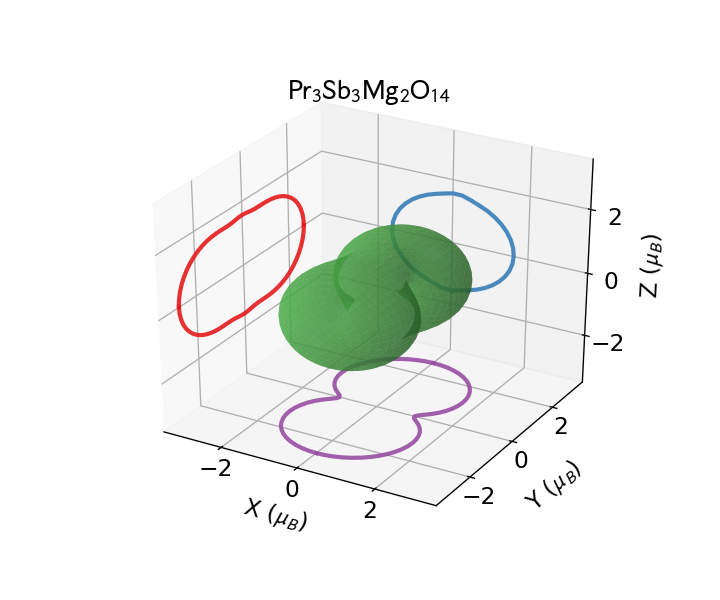

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri

scale = 1

plt.rc('font',**{'size':14})
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

fig3 = plt.figure(figsize=(6,5))
ax1 = fig3.add_subplot(111, projection='3d')

# Plot the surface
ax1.plot_surface(x*scale, y*scale, z*scale, color=cpal1[2], rstride=1, cstride=1, alpha=0.65, zorder=10)
surfacelineattributes = {'alpha':0.9, 'lw':2.5, 'zorder':-1}
ax1.plot(x[20]-3.55,y[20],z[20], c=cpal1[0], **surfacelineattributes)
ax1.plot(x[20]-3.55,y[20],-z[20], c=cpal1[0], **surfacelineattributes)
# ax1.plot(x[:,20],y[:,20],z[:,20], c=cpal1[0], **surfacelineattributes) # cross section about middle
# ax1.plot(surfaceXoutline[0],surfaceXoutline[1],surfaceXoutline[2], c=cpal1[0], **surfacelineattributes)
ax1.plot(surfaceZoutline[0],surfaceZoutline[1],surfaceZoutline[2], c=cpal1[3], **surfacelineattributes)
ax1.plot(-surfaceZoutline[0],surfaceZoutline[1],surfaceZoutline[2], c=cpal1[3], **surfacelineattributes)
ax1.plot(surfaceYoutline[0],surfaceYoutline[1],surfaceYoutline[2], c=cpal1[1], **surfacelineattributes)

# ax1.view_init(17, -65)

ax1.set_xlabel('X ($\mu_B$)', labelpad=1)
ax1.set_ylabel('Y ($\mu_B$)')
ax1.set_zlabel('Z ($\mu_B$)')
ax1.set_xlim(-3.40,3.4)
ax1.set_ylim(-3.40,3.4)
ax1.set_zlim(-3.40,3.4)
ax1.tick_params(axis='z', pad=1)
ax1.tick_params(axis='x', pad=-3)
ax1.tick_params(axis='y', pad=-3)
ax1.set_xticks([-2,0,2])
ax1.set_yticks([-2,0,2])
ax1.set_zticks([-2,0,2])

ax1.set_title('$\\rm{Pr_3Sb_3Mg_2O_{14}}$')

figdir = '/home/allen/Documents/Neutrons/Nd3Sb3Mg2O14/ARCS_Exp/Paper/Figures/'
plt.savefig(figdir+'NdKag_Fig_PrMg_Anisotropy.pdf',  bbox_inches='tight',pad_inches = 0.2)

In [17]:
with open('PrMg_CEF_AnisotropyPlot.pickle', 'wb') as f:
    pickle.dump((x, y, z, surfaceYoutline, surfaceZoutline), f)